# Introduction to feed-forward neural networks

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Assistants: Dr.-Ing. Maximilian Kannapin, Jasper O. Schommartz, Dominik K. Klein

Summer term 2024

---


### In this notebook, you will...


*   Calibrate feed-forward neural networks to different one-dimensional datasets
*   Learn the influence of hyperparameters on the calibrated model
* Learn the difference between interpolation and extrapolation
*   Learn to construct convex and monotonous neural networks






*Run the following cell to clone the GitHub repository in your current Google Colab environment.*

In [1]:
!git clone https://github.com/CPShub/LecturePhysicsAwareML.git

Cloning into 'LecturePhysicsAwareML'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 180 (delta 14), reused 23 (delta 9), pack-reused 141
Receiving objects: 100% (180/180), 42.20 MiB | 14.11 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Updating files: 100% (62/62), done.


*Run the following cell to import all modules and python files to this notebook. If you made changes in the python files, run the following cell again to update the python files in this notebook. You might need to restart your Colab session first ("Runtime / Restart session" in the header menu).*


In [ ]:
import tensorflow as tf
import datetime
now = datetime.datetime.now
import LecturePhysicsAwareML.FFNN_introduction.data as ld
import LecturePhysicsAwareML.FFNN_introduction.models as lm
import LecturePhysicsAwareML.FFNN_introduction.plots as lp

*Run this cell if you are executing the notebook locally on your device.*

In [1]:
import tensorflow as tf
import datetime
now = datetime.datetime.now
import data as ld
import models as lm
import plots as lp

2024-08-25 14:05:25.977311: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 14:05:25.977353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 14:05:25.978550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 14:05:25.984469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


*If you want to clone the repository again, you have to delete it from your Google Colab files first. For this, you can run the following cell.*

In [ ]:
%rm -rf LecturePhysicsAwareML

## Task 1: Nonlinear regression


''In a nutshell, feed-forward neural networks (FFNNs) can be seen as a composition of several vector-valued functions, where the components of the vectors are referred to as nodes or neurons, and the function in each neuron is referred to as activation function. More explicitely, the FFNN with the vector-valued inpout $\boldsymbol{x}=:\boldsymbol{A}_0\in\mathbb{R}^{n^{[0]}}$, output $\boldsymbol{y}=:\boldsymbol{A}_{[H+1]}\in\mathbb{R}^{n^{[H+1]}}$, and $H$ hidden layers is given by


\begin{equation}
\boldsymbol{A}_h=\sigma^{[h]}\left(\boldsymbol{w}^T\boldsymbol{x}+\boldsymbol{b}\right)\in\mathbb{R}^{n^{[h]}}\,,\qquad h=1,...,H+1\,.
\end{equation}


Here, $\boldsymbol{w}^{[h]}\in\mathbb{R}^{n^{[h]}\times n^{[h-1]}}$ are the weights and $\boldsymbol{b}\in\mathbb{R}^{n^{[h]}}$ the bias in each layer. Together, they form the set of parameters $\boldsymbol{\phi}$ of the neural network, which is optimized in the calibration process to fit a given dataset. In the layers $\boldsymbol{A}_h$, the scalar activation functions $\sigma^{[h]}$ are applied in a component-wise manner.'' (Klein et al., CMAME 400:115501) A FFNN has different hyperparameters. Here, the hyperparameters are given by the number of nodes and layers and the activation functions.

<br>

After fixing the FFNNs hyperparameters, it can be calibrated to fit a given dataset. In this notebook, we consider datasets of the form

\begin{equation}
\mathcal{D}=\big\{(x_i,\,y_i) \big\}_{i=1,...,D}\,,\qquad x_i\in\mathbb{R},\,y_i\in\mathbb{R}\,.
\end{equation}


Consequently, input and output of the FFNNs are also scalar-valued, i.e., $\mathbb{R}^{n^{[0]}}=\mathbb{R}^{n^{[H+1]}}=1$. The parameters $\boldsymbol{\phi}$ of the FFNN are determined such that it best-approximates the data $\mathcal{D}$. Typically, this is done by minimizing a loss (or cost) function which provides a measure for the difference between data and FFNN model prediction. Here, the mean-squared error (MSE) is applied:


\begin{equation}
\operatorname{MSE}(\boldsymbol{\phi},\,\mathcal{D})=\frac{1}{D}\sum_{d=1}^D\lvert\lvert \operatorname{FFNN}(x_i,\,\boldsymbol{\phi})-y_i\rvert\rvert_2^2
\end{equation}


Since this is a highly nonlinear minimisation problem, iterative solution methods are applied. The number of iterations (or epochs) in the optimization process influences the quality of the calibrated model.

<br>

### Tasks

Despite their simple structure, FFNNs can represent basically every continuous function. Here, this is demonstrated by calibrating different FFNNs to different datasets. Furthermore, the influence of model and calibration hyperparameters are investigated.


*  Calibrate FFNNs to different datasets ('bathtub', 'curve', 'double_curve')
* Vary the number of hidden layers in [1, 2, 3] and the number of nodes in [4, 8, 16].
* Vary the number of epochs in the parameter optimization process in [500, 1000, 2500, 3000].
* Use different activation functions, e.g., Relu, Softplus and Sigmoid. Use a linear activation function in the output layer.

Note that you do not have to evaluate all possible combinations, but only enough to understand the influence of the different hyperparameters.



In [2]:

devices = tf.config.list_physical_devices()
for device in devices:
    print("Name:", device.name, "  Type:", device.device_type)

if len(devices) > 1:
    tf.config.set_logical_device_configuration(
            devices[1],
            [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])
tf.debugging.set_log_device_placement(False)


Name: /physical_device:CPU:0   Type: CPU
Name: /physical_device:GPU:0   Type: GPU


2024-08-25 14:05:29.135528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-25 14:05:29.141175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-25 14:05:29.141386: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-08-25 14:35:20.485335
it took 0:00:33.540124 (sec) to calibrate the model


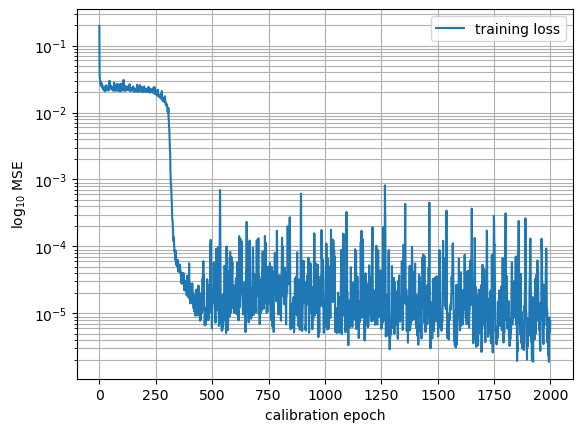

16/16 [==============================] - 0s 699us/step


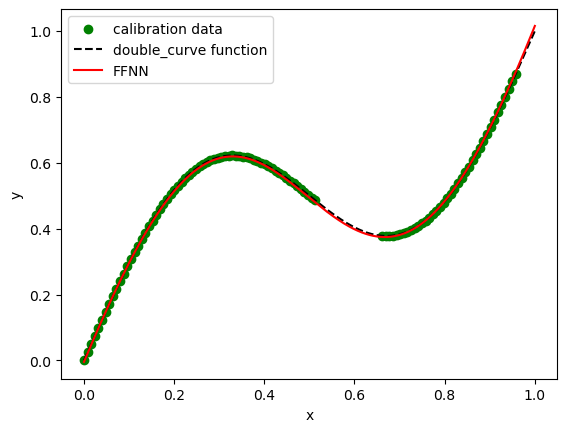

In [41]:
# Set random seed
tf.random.set_seed(seed=0)

# Adapt the model name for your plots
model_name = 'FFNN'

# Number of nodes in each layer
units = [100,100,100,1]

# Activation function in each layer
# Options: 'softplus', 'tanh', 'relu', 'linear', ...
activation = ['softplus','softplus','softplus','linear']

with tf.device("CPU:0"):

    # Load model
    model = lm.main(units=units, activation=activation)
    
    # Dataset options: 'bathtub', 'curve', 'double_curve'
    data = 'double_curve'
    
    # Epochs: number of iterations in the optimisation process
    epochs = 2000
    
    # Load data
    xs, ys, xs_c, ys_c = ld.get_data(data)
    
    # Calibrate model
    t1 = now()
    print(t1)
    
    # set "verbose=2" to observe the progress of the calibration process
    model.optimizer.learning_rate.assign(0.001)
    h = model.fit([xs_c], [ys_c], epochs=epochs, verbose=False, shuffle=True, batch_size=20)
    
    t2 = now()
    print('it took', t2 - t1, '(sec) to calibrate the model')
    
    # Plot loss and prediction
    lp.plot_loss(h)
    lp.plot_data_model(xs, ys, xs_c, ys_c, model, model_name, data, 4)

## Task 2: Convex and monotonous neural networks

''To lay the foundational intuition for constructing convex and monotonus neural networks, we first consider the univariate function


\begin{equation}
f:\mathbb{R}\rightarrow\mathbb{R},\quad x\mapsto f(x):=(g\circ h)(x)=g(h(x))\,,
\end{equation}


where $f$ is composed of two functions $g,h:\mathbb{R}\rightarrow \mathbb{R}$. Given that all of these functions are twice continuously differentiable, convexity of $f$ in $x$ is equivalent to the nonnegativity of the second derivative


\begin{equation}
f''(x)=(g''\circ h)(x)\, h'(x)^2 + (g' \circ h)(x)\, h''(x) \geq 0\,.
\end{equation}


A sufficient, albeit not necessary condition for this is that the function $h$ is convex ($h''\geq 0$), while the function $g$ is convex and nondecreasing ($g'\geq 0,\,g''\geq 0$). Conversely, if a function acting on a convex function does not fulfill these conditions, the resulting function is not necessarily convex. The recursive application of above equation yields conditions for arbitrary many function compositions. The innermost function, here $h$, must only be convex, while every followung function must be convex and nondecreasing to preserve conxevity.

The generalization to compositions of multivariate functions is also straightforward. For this, we consider the function

\begin{equation}
f:\mathbb{R}^m\rightarrow\mathbb{R},\qquad\boldsymbol{x}\mapsto f(\boldsymbol{x}):=(g\circ\boldsymbol{h})(\boldsymbol{x})\,,
\end{equation}

with $\boldsymbol{h}:\mathbb{R}^m\rightarrow\mathbb{R}^n$ and $g:\mathbb{R}^n\rightarrow\mathbb{R}$. Given that all of these functions are twice continuously differentiable, convexity of $f$ in $\mathbb{x}$ is equivalent to the positive semi-definiteness of its Hessian. Similar reasoning as above leads to the sufficient condition that $\boldsymbol{h}$ must be component-wise convex, while $g$ must be convex and nondecreasing, see (Klein et al, JMPS 159:104703) for an explicit proof. Again, the recursive application of this yields conditions for arbitrary many function compositions. Here, the innermost function must be component-wise convex, while every following function must be component-wise convex and nondecreasing to preserve convexity.

In the same manner, the composite function $f$ is monotonically increasing (or nondecreasing) when its first derivative

\begin{equation}
f'(x)=(g'\circ h)(x)h'(x)\geq 0
\end{equation}

is nonnegative, which is fulfilled when both $g$ and $h$ are nondecreasing functions ($g'\geq 0,\,h'\geq0$). The recursive application of this yields again conditions for arbitrary many function compositions. When all functions within a composite function are nondecreasing, the overall function is nondecreasing. In this case, the generalization to compositions of vector-valued functions leads to the condition that all functions must be component-wise nondecreasing.
 '' (Klein et al., DCE 4:e25)


<br>

To summarize, sufficient conditions for convex neural networks are


*   A convex activation function in the first hidden layer
*   Convex and non-decreasing activation functions in every subsequent layer
* Non-negative weights in every layer beside the first one

Convex neural networks were originally proposed by Amos et al. (2017).

Sufficient conditions for monotonous neural networks are

*  Monotonous activation functions in every layer
* Non-negative weights in every layer


<br>

### Tasks

* Construct convex FFNNs (C-FFNNs) and monotonous FFNNs (M-FFNNs) by using suitable activation functions and restrictions to the weights of the FFNN.
* How do you have to construct M-FFNNs which are monotonous, but not convex?
* Calibrate C-FFNNs and M-FFNNs to the datasets introduced above. What do you observe?
* For this, consider the following activation functions:

\begin{equation}
\begin{aligned}
\text{Softplus}:\qquad \sigma(x)&=\log(1+e^x)
\\
\text{Tanh}:\qquad \sigma(x)&=\operatorname{tanh}(x)=\frac{e^{2x}-1}{e^{2x}+1}
\\
\text{Linear}:\qquad \sigma(x)&=x
\end{aligned}
\end{equation}

* Which of these functions are convex and / or non-decreasing?

In [1]:
# Adapt the model name for your plots
model_name = 'FFNN'

# Number of nodes in each layer
units = [32,32,1]

# Activation function in each layer
# Options: 'softplus', 'tanh', 'relu', 'linear', ...
activation = ['softplus','softplus','linear']

# non_neg: restrict the weights in different layers to be non-negative
non_neg = [False, True, False]

# Dataset options: 'bathtub', 'curve', 'double_curve'
data = 'curve'

# epochs: number of iterations in the optimisation process
epochs = 3000

 # Load model
model = lm.main_con(units=units, activation=activation, non_neg=non_neg)

# Load data
xs, ys, xs_c, ys_c = ld.get_data(data)

# Calibrate model
t1 = now()
print(t1)

#   set "verbose=2" to observe the progress of the calibration process
model.optimizer.learning_rate.assign(0.002)
h = model.fit([xs_c], [ys_c], epochs = epochs,  verbose = 0)

t2 = now()
print('it took', t2 - t1, '(sec) to calibrate the model')

# Plot loss and prediction
lp.plot_loss(h)
lp.plot_data_model(xs, ys, xs_c, ys_c, model, model_name, data, 4)

NameError: name 'lm' is not defined

## Task 3: Sobolev training

We now consider datasets of the form

\begin{equation}
\mathcal{D}=\big\{(x_i,\,y_i,\,y'_i) \big\}_{i=1,...,D}\,,\qquad x_i\in\mathbb{R},\,y_i\in\mathbb{R},\,y'_i\in\mathbb{R}\,,
\end{equation}

where $y'_i$ is the gradient of the function $y_i$ at the position $x_i$. In this case, a NN can be calibrated both on its original output and on its derivative. For that, the adapted loss function

\begin{equation}
\begin{aligned}
\operatorname{MSE}(\boldsymbol{\phi},\,\mathcal{D})=\frac{1}{D}\sum_{d=1}^D&w_{\text{function}}\lvert\lvert \operatorname{FFNN}(x_i,\,\boldsymbol{\phi})-y_i\rvert\rvert_2^2
\\
+&w_{\text{gradient}}\Big\lvert\Big\lvert \frac{\partial \operatorname{FFNN}(x_i,\,\boldsymbol{\phi})}{\partial x_i}-y'_i\Big\rvert\Big\rvert_2^2
\end{aligned}
\end{equation}

is applied. Calibrating a NN on its gradients is usually referred to as *Sobolev training*.
<br>

### Tasks

Apply the following calibration strategies:
*  Calibration only on the function itself ($w_{\text{function}}=1$, $w_{\text{gradient}}$=0)
*  Calibration only on the gradient ($w_{\text{function}}=0$, $w_{\text{gradient}}$=1)
*  Calibration on the function and its gradient ($w_{\text{function}}=1$, $w_{\text{gradient}}$=1)

Evaluate the NN model prediction for both the function and its gradient for all three strategies. Furthermore, compare the gradients of standard FFNNs / M-FFNNs / C-FFNNs. What do you observe?

2024-05-22 10:07:34.599579
it took 0:02:24.999159 (sec) to calibrate the model


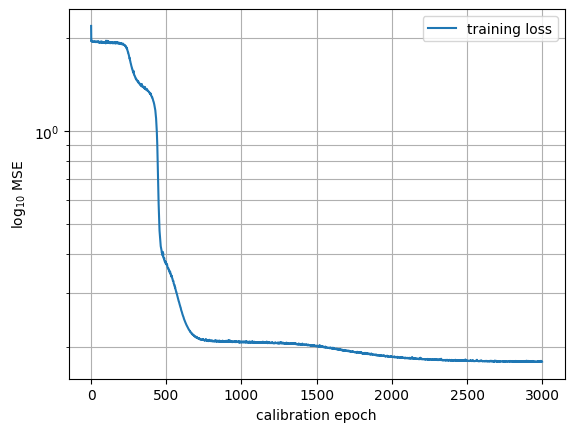

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


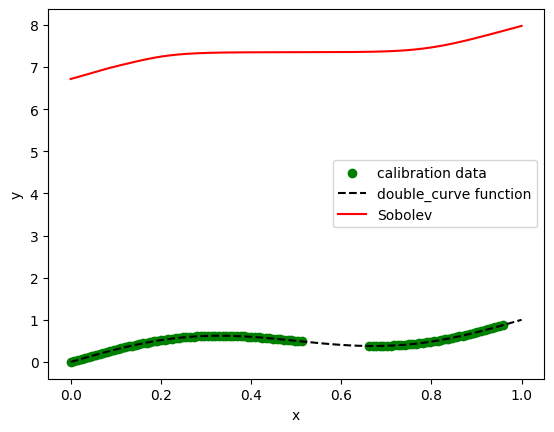

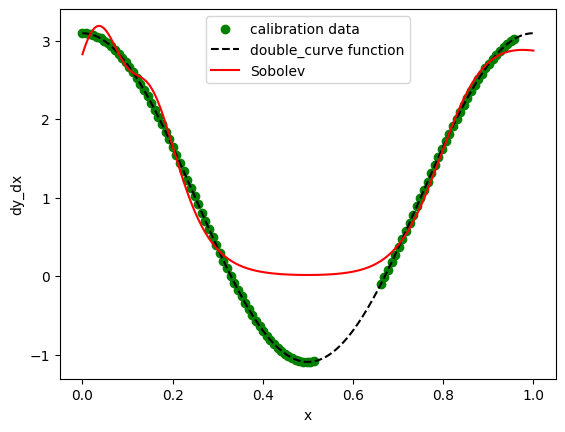

In [5]:
# Adapt the model name for your plots
model_name = 'Sobolev'

# Number of nodes in each layer
units = [32,32,1]

# Activation function in each layer
# Options: 'softplus', 'tanh', 'relu', 'linear', ...
activation = ['tanh','softplus','linear']

# non_neg: restrict the weights in different layers to be non-negative
non_neg = [True, True, True]

# Dataset options: 'bathtub', 'curve', 'double_curve'
data = 'double_curve'

# epochs: number of iterations in the optimisation process
epochs = 3000

# Set loss_weights to define the calibration process...
# ...[1,0] calibration only on the function
# ...[0,1] calibration only on the gradient
# ...[1,1] calibration on the function and its gradient
loss_weights=[0,1]

# Load model
model = lm.main_con_grad(loss_weights=loss_weights, \
                         units=units, activation=activation, non_neg=non_neg)

# Load data
xs, ys, dys, xs_c, ys_c, dys_c = ld.get_data_with_gradients(data)

# Calibrate model
t1 = now()
print(t1)

# set "verbose=2" to observe the progress of the calibration process
model.optimizer.learning_rate.assign(0.002)
h = model.fit([xs_c], [ys_c, dys_c], epochs = epochs,  verbose = 0)

t2 = now()
print('it took', t2 - t1, '(sec) to calibrate the model')

# Plot loss and prediction
lp.plot_loss(h)
lp.plot_data_model_grad(xs, ys, dys, xs_c, ys_c, dys_c, model, model_name, data, 4)